In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # 📊 Progress bar
import matplotlib.pyplot as plt
import numpy as np
import pandas  as pd
import mediapipe


/home/pegasus/anaconda3/envs/light-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pegasus/anaconda3/envs/light-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
#!pip install mediapipe

  Using cached mediapipe-0.10.21-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached jax-0.5.3-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.5.3-cp310-cp310-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached sounddevice-0.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached sentencepiece-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached cffi-1.17.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached ml_dtypes-0.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached pycparser-2.22-py3-none-any.whl.me

In [20]:
train_path = "/home/pegasus/Documents/sign-translator/archive/ASL_Dataset/Train"
test_path = "/home/pegasus/Documents/sign-translator/archive/ASL_Dataset/Test"


In [21]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Try loading the dataset
train_data = datasets.ImageFolder(root="/home/pegasus/Documents/sign-translator/archive/ASL_Dataset/Train", transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

print("Dataset loaded successfully! Classes:", train_data.classes)


Dataset loaded successfully! Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [22]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scale to [-1, 1]
])


In [23]:
# Get one batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Batch shape:", images.shape)  # Expected: (batch_size, 3, 224, 224)

# Check min & max pixel values AFTER transformation
print("Min pixel value:", images.min().item())  # Expected ~-1
print("Max pixel value:", images.max().item())  # Expected ~1


Batch shape: torch.Size([32, 3, 224, 224])
Min pixel value: -1.0
Max pixel value: 0.6705882549285889


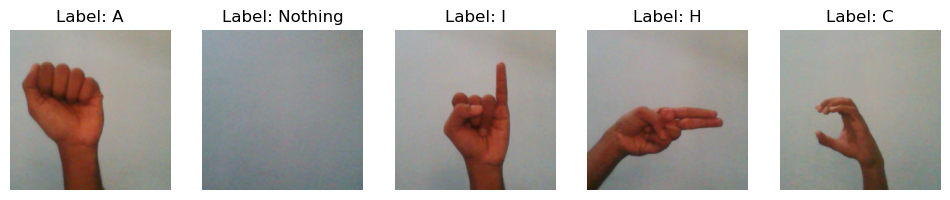

In [24]:


# Function to undo normalization for visualization
def unnormalize(img):
    img = img * 0.5 + 0.5  # Convert from [-1,1] back to [0,1]
    return img.permute(1, 2, 0).numpy()  # Convert (C, H, W) → (H, W, C)

# Show first 5 images
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    axes[i].imshow(unnormalize(images[i]))  # Show image
    axes[i].set_title(f"Label: {train_data.classes[labels[i]]}")
    axes[i].axis("off")

plt.show()


In [ ]:

# 🚀 Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"🔥 GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ No GPU detected, using CPU.")

# Define transformations (including normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
])

# 📂 Set save folder to Documents
save_folder = os.path.expanduser("~/Documents")
os.makedirs(save_folder, exist_ok=True)  # Create folder if it doesn't exist

def convert_to_numpy(data_path, save_name):
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    
    # 🔥 Optimized DataLoader: Small batch size + num_workers
    dataloader = DataLoader(dataset, batch_size=8, shuffle=False, 
                            num_workers=2, pin_memory=True)

    # Create output file in write mode (avoid storing large arrays in memory)
    save_path = os.path.join(save_folder, f"{save_name}.npz")
    npz_file = np.savez_compressed(save_path, X=[], y=[])  # Placeholder

    print(f"\n📂 Processing dataset: {data_path}")

    with open(save_path, 'wb') as f:
        for images, labels in tqdm(dataloader, desc=f"Saving {save_name}", unit="batch"):
            images = images.to(device)  # Move to GPU
            images = images.cpu().numpy()  # Move back to CPU for saving
            labels = labels.numpy()
            
            # 📝 Save data incrementally to avoid RAM overflow
            np.savez_compressed(f, X=images, y=labels)

            # 🚀 Free GPU memory
            del images, labels
            torch.cuda.empty_cache()

    print(f"✅ Saved in Documents: {save_path}")

# Convert Train and Test Data
convert_to_numpy(os.path.expanduser("~/Documents/sign-translator/archive/ASL_Dataset/Train"), "asl_train_normalized")
convert_to_numpy(os.path.expanduser("~/Documents/sign-translator/archive/ASL_Dataset/Test"), "asl_test_normalized")

print(f"🎉 All datasets saved in 📂 {save_folder}!")


In [ ]:
import numpy as np

# Load the train dataset
train_data = np.load("asl_train_normalized.npz")

# Convert images from float32 to uint8 (if not already)
X_train = (train_data["X"] * 255).astype(np.uint8)  # Convert to 0-255 range
y_train = train_data["y"]

# Save with compression
np.savez_compressed("asl_train_fixed.npz", X=X_train, y=y_train)

print(f"✅ Compressed Train Data Saved! (Old: 19GB ➝ New: MUCH smaller)")


✅ Compressed Train Data Saved! (Old: 19GB ➝ New: MUCH smaller)


In [ ]:
from torch.utils.data import random_split

# 80% Train, 20% Validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"✅ Train: {len(train_dataset)} | Validation: {len(val_dataset)}")


✅ Train: 132536 | Validation: 33134


In [26]:

# 🚀 Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"💙 GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ No GPU detected, using CPU.")

# ✅ Define transformations (resizing, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# 📂 Load the dataset
batch_size = 32
train_path = os.path.expanduser("~/Documents/sign-translator/archive/ASL_Dataset/Train")
test_path = os.path.expanduser("~/Documents/sign-translator/archive/ASL_Dataset/Test")

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# 🏗️ Define an optimized CNN model
class ASLCNN(nn.Module):
    def __init__(self, num_classes=28):
        super(ASLCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)7
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# 🚀 Initialize the model and move it to GPU
model = ASLCNN(num_classes=28).to(device)

# 🔧 Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🏋️ Training loop with Blue Progress Bar
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"🔵 Training Epoch {epoch+1}/{num_epochs}", unit="batch", colour="blue")
    
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())  # Update progress bar with loss

    print(f"💙 Epoch [{epoch+1}/{num_epochs}] - Avg Loss: {running_loss/len(train_loader):.4f}")

print("🎉 Training Complete!")

# 📊 Evaluate on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="🔷 Evaluating", unit="batch", colour="cyan"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"🔹 Test Accuracy: {100 * correct / total:.2f}%")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (3005210231.py, line 41)

In [ ]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss
}
torch.save(checkpoint, "checkpoint.pth")
print("💾 Checkpoint Saved: checkpoint.pth")


In [6]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# 📁 Path to test dataset
test_path = os.path.expanduser("~/Documents/sign-translator/archive/ASL_Dataset/Test")

# 🧼 Transformations (NO data augmentation, just resize + normalize)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 📦 Load test dataset
test_dataset = datasets.ImageFolder(root=test_path, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import torch

# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="🔷 Evaluating", unit="batch", colour="cyan"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"🔹 Test Accuracy: {accuracy:.2f}%")


NameError: name 'model' is not defined

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# ✅ Ensure model is in eval mode
model.eval()

# ✅ Get class names from the dataset
class_names = test_dataset.classes

# ✅ Randomly pick 5 indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 5)

# ✅ Plot images with predictions
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    # Unnormalize the image for visualization
    image_np = image.numpy().transpose(1, 2, 0)
    image_np = (image_np * 0.5) + 0.5  # De-normalize from [-1,1] to [0,1]

    axes[i].imshow(image_np)
    axes[i].set_title(f"✅ True: {class_names[label]}\n🔮 Pred: {class_names[predicted.item()]}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

In [5]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 👇 Make sure your model is in eval mode
model.eval()

# 👇 Gather all true and predicted labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes  # automatically grabs folder names

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ✅ Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("📊 Classification Report:\n")
print(report)


NameError: name 'model' is not defined

In [37]:
print(len(test_path))
          

64


In [4]:
import random
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

class_names = test_dataset.classes

fig, ax = plt.subplots(figsize=(14, 8))
grid = make_grid(images[:16].cpu(), nrow=4, normalize=True)
ax.imshow(grid.permute(1, 2, 0))
ax.axis("off")
ax.set_title("Predicted: " + ", ".join([class_names[p] for p in preds[:16].cpu()]))
plt.show()


NameError: name 'model' is not defined

In [21]:
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)


In [24]:
class_names = test_dataset.classes  # ✅ This works!
print(class_names, end=" ")


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] 

In [3]:
import cv2
import torch
import mediapipe as mp
import numpy as np
import os
from torchvision import transforms
from PIL import Image

# Replace this with your actual path to test data folder
test_path = "/home/pegasus/Documents/sign-translator/archive/ASL_Dataset/Test"
labels = sorted(os.listdir(test_path))  # Extract class labels from folder names

# ✅ Load model and set to eval mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ✅ Initialize MediaPipe for hand detection
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)
mp_draw = mp.solutions.drawing_utils

# ✅ Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(image_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            # Get bounding box
            h, w, _ = frame.shape
            x_min = int(min([lm.x for lm in hand_landmarks.landmark]) * w)
            y_min = int(min([lm.y for lm in hand_landmarks.landmark]) * h)
            x_max = int(max([lm.x for lm in hand_landmarks.landmark]) * w)
            y_max = int(max([lm.y for lm in hand_landmarks.landmark]) * h)

            # Add margin
            margin = 20
            x_min = max(x_min - margin, 0)
            y_min = max(y_min - margin, 0)
            x_max = min(x_max + margin, w)
            y_max = min(y_max + margin, h)

            # Crop and preprocess
            hand_roi = frame[y_min:y_max, x_min:x_max]
            if hand_roi.size == 0:
                continue  # Avoid errors on bad crop

            hand_image = cv2.cvtColor(hand_roi, cv2.COLOR_BGR2RGB)
            hand_pil = Image.fromarray(hand_image)

            input_tensor = transform(hand_pil).unsqueeze(0).to(device)

            # Predict
            with torch.no_grad():
                output = model(input_tensor)
                pred = torch.argmax(output, 1)
                predicted_label = labels[pred.item()]

            # Draw
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(frame, f"{predicted_label}", (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    else:
        cv2.putText(frame, "✋ Show your hand", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    cv2.imshow("ASL Live Prediction", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# ✅ Cleanup
cap.release()
cv2.destroyAllWindows()


NameError: name 'model' is not defined

In [16]:
import cv2
import torch
import mediapipe as mp
import numpy as np
import os
from torchvision import transforms
from PIL import Image
import torch.nn as nn

# ✅ Define the model architecture (must match trained one)
class ASLCNN(nn.Module):
    def __init__(self, num_classes=28):
        super(ASLCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),  # Make sure image size = 224x224
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# ✅ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Instantiate and load model
model = ASLCNN(num_classes=28).to(device)
checkpoint = torch.load("checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# ✅ Label extraction
test_path = "/home/pegasus/Documents/sign-translator/archive/ASL_Dataset/Test"
labels = sorted(os.listdir(test_path))

# ✅ Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ✅ Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)
mp_draw = mp.solutions.drawing_utils

# ✅ Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(image_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            h, w, _ = frame.shape
            x_min = int(min([lm.x for lm in hand_landmarks.landmark]) * w)
            y_min = int(min([lm.y for lm in hand_landmarks.landmark]) * h)
            x_max = int(max([lm.x for lm in hand_landmarks.landmark]) * w)
            y_max = int(max([lm.y for lm in hand_landmarks.landmark]) * h)

            margin = 20
            x_min = max(x_min - margin, 0)
            y_min = max(y_min - margin, 0)
            x_max = min(x_max + margin, w)
            y_max = min(y_max + margin, h)

            hand_roi = frame[y_min:y_max, x_min:x_max]
            if hand_roi.size == 0:
                continue

            hand_image = cv2.cvtColor(hand_roi, cv2.COLOR_BGR2RGB)
            hand_pil = Image.fromarray(hand_image)
            input_tensor = transform(hand_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                pred = torch.argmax(output, 1)
                predicted_label = labels[pred.item()]

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(frame, f"{predicted_label}", (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    else:
        cv2.putText(frame, "✋ Show your hand", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    cv2.imshow("ASL Live Prediction", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# ✅ Cleanup
cap.release()
cv2.destroyAllWindows()


/tmp/ipykernel_10113/482508900.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint.pth", map_location=device)
I0000 00:00:1744285603.164

In [ ]:
# Add at the top with other imports
import cv2
import torch
import mediapipe as mp
import numpy as np
import os
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import time

# Model Definition remains unchanged
class ASLCNN(nn.Module):
    def __init__(self, num_classes=28):
        super(ASLCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Device and Model Loading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLCNN(num_classes=28).to(device)
checkpoint = torch.load("checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Labels and transform
test_path = "/home/pegasus/Documents/sign-translator/archive/ASL_Dataset/Test"
labels = sorted(os.listdir(test_path))
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# MediaPipe and Webcam
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)
mp_draw = mp.solutions.drawing_utils
cap = cv2.VideoCapture(0)

# Word and tracking
current_prediction = ""
start_time = None
word = ""
click_x, click_y = -1, -1

# Mouse callback to track clicks
def mouse_callback(event, x, y, flags, param):
    global click_x, click_y
    if event == cv2.EVENT_LBUTTONDOWN:
        click_x, click_y = x, y

cv2.namedWindow("ASL Live Prediction")
cv2.setMouseCallback("ASL Live Prediction", mouse_callback)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(image_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            h, w, _ = frame.shape
            x_min = int(min([lm.x for lm in hand_landmarks.landmark]) * w)
            y_min = int(min([lm.y for lm in hand_landmarks.landmark]) * h)
            x_max = int(max([lm.x for lm in hand_landmarks.landmark]) * w)
            y_max = int(max([lm.y for lm in hand_landmarks.landmark]) * h)

            margin = 20
            x_min = max(x_min - margin, 0)
            y_min = max(y_min - margin, 0)
            x_max = min(x_max + margin, w)
            y_max = min(y_max + margin, h)

            hand_roi = frame[y_min:y_max, x_min:x_max]
            if hand_roi.size == 0:
                continue

            hand_image = cv2.cvtColor(hand_roi, cv2.COLOR_BGR2RGB)
            hand_pil = Image.fromarray(hand_image)
            input_tensor = transform(hand_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                pred = torch.argmax(output, 1)
                predicted_label = labels[pred.item()]

            # Timer-based prediction
            i# Time logic: Add letter or space after 1 second hold
            if predicted_label == current_prediction:
                if time.time() - start_time >= 1:
                    # Add space (real one, not string "space")
                    if predicted_label == "space":
                        if len(word) > 0 and word[-1] != " ":
                            word += " "
                    # Add letter if it's different from last one
                    elif len(word) == 0 or (word and word[-1] != predicted_label):
                        word += predicted_label
                    start_time = time.time()
            else:
                current_prediction = predicted_label
                start_time = time.time()


            # Draw prediction
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(frame, predicted_label, (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    else:
        current_prediction = ""
        start_time = None
        cv2.putText(frame, "✋ Show your hand", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    # Draw word box
    cv2.rectangle(frame, (20, 400), (700, 470), (255, 255, 255), -1)
    cv2.putText(frame, f"Word: {word}", (30, 440),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # Draw DELETE button
    delete_button = (620, 410, 690, 460)  # (x1, y1, x2, y2)
    cv2.rectangle(frame, (delete_button[0], delete_button[1]),
                         (delete_button[2], delete_button[3]), (0, 0, 255), -1)
    cv2.putText(frame, "Delete", (delete_button[0]+5, delete_button[1]+35),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    # Handle mouse click on Delete button
    if delete_button[0] <= click_x <= delete_button[2] and delete_button[1] <= click_y <= delete_button[3]:
        word = word[:-1]
        click_x, click_y = -1, -1  # Reset click after action

    cv2.imshow("ASL Live Prediction", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


/tmp/ipykernel_10113/221455791.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint.pth", map_location=device)
I0000 00:00:1744286085.728